# Libraries

In [85]:
import pandas as pd
from getpass import getuser
from scipy.stats import ttest_rel, wilcoxon  
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
# Get the current user's name
user = getuser()


# Load Data

In [87]:
# ---- EURO datasets ----
data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\uefa\eu\goals_eu_uefa.xlsx'
goals_eu_uefa = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\fifa\eu\goals_eu_fifa.xlsx'
goals_eu_fifa = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\uefa\eu\mbm_eu_uefa.xlsx'
mbm_eu_uefa = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\fifa\eu\mbm_eu_fifa.xlsx'
mbm_eu_fifa = pd.read_excel(data_path)

# ---- WORLD CUP datasets ----
data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\uefa\wc\goals_wc_uefa.xlsx'
goals_wc_uefa = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\fifa\wc\goals_wc_fifa.xlsx'
goals_wc_fifa = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\uefa\wc\mbm_wc_uefa.xlsx'
mbm_wc_uefa = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\fifa\wc\mbm_wc_fifa.xlsx'
mbm_wc_fifa = pd.read_excel(data_path)

# ---- Elo files ----
data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\in\elo_eu.xlsx'
elo_eu = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\in\elo_wc.xlsx'
elo_wc = pd.read_excel(data_path)

# ---- shock, suspense, surprise ----
data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\uefa\eu\tab_prob_eu_uefa.xlsx'
sss_eu = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\fifa\wc\tab_prob_fifa_wc.xlsx'
sss_wc= pd.read_excel(data_path)


In [88]:
# Dictionary of replacements
replacements = {
    "Republic of Ireland": "Ireland",
    "CIS": "Commonwealth of Independent States",
    "FR Yugoslavia": "Yugoslavia"
}

# List of all relevant DataFrames
datasets = [
    goals_eu_uefa, goals_eu_fifa, mbm_eu_uefa, mbm_eu_fifa,
    goals_wc_uefa, goals_wc_fifa, mbm_wc_uefa, mbm_wc_fifa
]

# Apply replacements to each dataset
for df in datasets:
    df['home_team'] = df['home_team'].replace(replacements)
    df['away_team'] = df['away_team'].replace(replacements)

# Optional: show one updated DataFrame
display(goals_eu_uefa)



,year,stage,date,time,goal_minute,half_time,home_team,away_team,scorer_team,new_top_teams,...,third_qualify,qualified_teams,qual_changed,qual_count,pts_diff,gls_diff,elo_home,elo_away,h2h,suspense
0,1984,Group 1,1984-06-19,20:30,0,NaN,NaN,NaN,NaN,"['France', 'Denmark']",...,0,"['France', 'Denmark']",0,0,0,-7,NaN,NaN,1,1
1,1984,Group 1,1984-06-19,20:30,26,1.0,Denmark,Belgium,Belgium,"['Belgium', 'France']",...,0,"['France', 'Belgium']",1,1,-2,5,1809.0,1898.0,1,1
2,1984,Group 1,1984-06-19,20:30,32,1.0,France,Yugoslavia,Yugoslavia,"['Belgium', 'France']",...,0,"['France', 'Belgium']",0,1,-2,5,1960.0,1890.0,1,1
3,1984,Group 1,1984-06-19,20:30,39,1.0,Denmark,Belgium,Belgium,"['Belgium', 'France']",...,0,"['France', 'Belgium']",0,1,-2,3,1809.0,1898.0,1,0
4,1984,Group 1,1984-06-19,20:30,41,1.0,Denmark,Belgium,Denmark,"['Belgium', 'France']",...,0,"['France', 'Belgium']",0,1,-2,5,1809.0,1898.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,2024,Group F,2024-06-26,21:00,2,1.0,Georgia,Portugal,Georgia,"['Portugal', 'Turkey', 'Georgia']",...,1,"['Portugal', 'Turkey', 'Georgia']",1,1,-2,0,1666.0,2002.0,0,1
266,2024,Group F,2024-06-26,21:00,51,2.0,Czech Republic,Turkey,Turkey,"['Portugal', 'Turkey', 'Georgia']",...,1,"['Portugal', 'Turkey', 'Georgia']",0,1,-3,-1,1777.0,1749.0,0,0
267,2024,Group F,2024-06-26,21:00,57,2.0,Georgia,Portugal,Georgia,"['Portugal', 'Turkey', 'Georgia']",...,1,"['Portugal', 'Turkey', 'Georgia']",0,1,-3,-2,1666.0,2002.0,0,0
268,2024,Group F,2024-06-26,21:00,66,2.0,Czech Republic,Turkey,Czech Republic,"['Portugal', 'Turkey', 'Georgia']",...,1,"['Portugal', 'Turkey', 'Georgia']",0,1,-2,-1,1777.0,1749.0,0,1


# aggregate measure for elo, suspense, and changes

In [89]:
def compute_aggregated_metrics(goals_df, elo_df):
    """
    Merges Elo ratings for home and away teams, computes average Elo per match,
    and aggregates average Elo, Elo standard deviation, qual_count, and suspense by year and stage.

    Parameters:
    - goals_df: DataFrame containing match data with 'home_team', 'away_team', 'year', 'stage', 'qual_count', and 'suspense'.
    - elo_df: DataFrame containing Elo ratings with 'team', 'year', and 'elo_rating'.

    Returns:
    - aggregated_df: DataFrame with aggregated metrics by year and group (formerly 'stage').
    """
    # Merge Elo rating for home_team
    merged_df = goals_df.merge(
        elo_df[['year', 'team', 'elo_rating']].rename(columns={'team': 'home_team', 'elo_rating': 'home_elo'}),
        on=['year', 'home_team'],
        how='left'
    )

    # Merge Elo rating for away_team
    merged_df = merged_df.merge(
        elo_df[['year', 'team', 'elo_rating']].rename(columns={'team': 'away_team', 'elo_rating': 'away_elo'}),
        on=['year', 'away_team'],
        how='left'
    )

    # Compute average Elo per match
    merged_df['elo_avg'] = merged_df[['home_elo', 'away_elo']].mean(axis=1)

    # Group and compute aggregate metrics
    aggregated_df = merged_df.groupby(['year', 'stage']).agg(
        elo_avg=('elo_avg', 'mean'),
        elo_std=('elo_avg', 'std'),  # <-- New line
        avg_qual_count=('qual_count', 'mean'),
        avg_suspense=('suspense', 'mean')
    ).reset_index()

    # Rename 'stage' to 'group'
    aggregated_df = aggregated_df.rename(columns={'stage': 'group'})
    return aggregated_df[['year', 'group', 'elo_avg', 'elo_std', 'avg_qual_count', 'avg_suspense']]


In [90]:
agg_goals_eu_uefa = compute_aggregated_metrics(goals_eu_uefa, elo_eu)
agg_goals_eu_fifa = compute_aggregated_metrics(goals_eu_fifa, elo_eu)
agg_mbm_eu_uefa = compute_aggregated_metrics(mbm_eu_uefa, elo_eu)
agg_mbm_eu_fifa = compute_aggregated_metrics(mbm_eu_fifa, elo_eu)


In [91]:
# ---- Compute aggregated metrics for World Cup datasets ----
agg_goals_wc_uefa = compute_aggregated_metrics(goals_wc_uefa, elo_wc)
agg_goals_wc_fifa = compute_aggregated_metrics(goals_wc_fifa, elo_wc)
agg_mbm_wc_uefa   = compute_aggregated_metrics(mbm_wc_uefa, elo_wc)
agg_mbm_wc_fifa   = compute_aggregated_metrics(mbm_wc_fifa, elo_wc)


## add manually elo_avg for 2024 Group C where no goal was scored

In [92]:
# Filter rows where elo_avg is NaN
missing_elo = agg_mbm_eu_uefa[agg_mbm_eu_uefa['elo_avg'].isna()]

# Display the result
print(missing_elo)


    year    group  elo_avg  elo_std  avg_qual_count  avg_suspense
40  2024  Group C      NaN      NaN             0.0           1.0


In [93]:
def patch_group_c_elo(agg_df, elo_df):
    group_c_teams = ['England', 'Denmark', 'Slovenia', 'Serbia']

    # Get average elo for the group
    group_c_elo = elo_df[(elo_df['year'] == 2024) & (elo_df['team'].isin(group_c_teams))]['elo_rating'].mean()

    # Fill in the missing elo_avg value
    agg_df.loc[
        (agg_df['year'] == 2024) & (agg_df['group'] == 'Group C'),
        'elo_avg'
    ] = group_c_elo

    return agg_df


In [94]:
agg_goals_eu_uefa = patch_group_c_elo(agg_goals_eu_uefa, elo_eu)
agg_goals_eu_fifa = patch_group_c_elo(agg_goals_eu_fifa, elo_eu)
agg_mbm_eu_uefa = patch_group_c_elo(agg_mbm_eu_uefa, elo_eu)
agg_mbm_eu_fifa = patch_group_c_elo(agg_mbm_eu_fifa, elo_eu)


In [95]:
# Filter rows where elo_avg is NaN
missing_elo = agg_mbm_wc_fifa[agg_mbm_wc_fifa['elo_avg'].isna()]

# Display the result
print(missing_elo)


Empty DataFrame
Columns: [year, group, elo_avg, elo_std, avg_qual_count, avg_suspense]
Index: []


# correlation analysis 

In [96]:
def show_correlations(df, dataset_name):
    # Select only numeric columns of interest
    corr_matrix = df[['elo_std', 'avg_qual_count', 'avg_suspense']].corr()

    print(f"\nCorrelation matrix for {dataset_name}:\n")
    print(corr_matrix)


In [97]:
# ---- Apply to EURO datasets ----
show_correlations(agg_goals_eu_uefa, 'agg_goals_eu_uefa')
show_correlations(agg_goals_eu_fifa, 'agg_goals_eu_fifa')
show_correlations(agg_mbm_eu_uefa, 'agg_mbm_eu_uefa')
show_correlations(agg_mbm_eu_fifa, 'agg_mbm_eu_fifa')

# ---- Apply to WORLD CUP datasets ----
show_correlations(agg_goals_wc_uefa, 'agg_goals_wc_uefa')
show_correlations(agg_goals_wc_fifa, 'agg_goals_wc_fifa')
show_correlations(agg_mbm_wc_uefa, 'agg_mbm_wc_uefa')
show_correlations(agg_mbm_wc_fifa, 'agg_mbm_wc_fifa')


Correlation matrix for agg_goals_eu_uefa:

                 elo_std  avg_qual_count  avg_suspense
elo_std         1.000000        0.105293      0.264441
avg_qual_count  0.105293        1.000000      0.252357
avg_suspense    0.264441        0.252357      1.000000

Correlation matrix for agg_goals_eu_fifa:

                 elo_std  avg_qual_count  avg_suspense
elo_std         1.000000        0.047972      0.248723
avg_qual_count  0.047972        1.000000      0.444604
avg_suspense    0.248723        0.444604      1.000000

Correlation matrix for agg_mbm_eu_uefa:

                 elo_std  avg_qual_count  avg_suspense
elo_std         1.000000        0.089860      0.114802
avg_qual_count  0.089860        1.000000      0.218186
avg_suspense    0.114802        0.218186      1.000000

Correlation matrix for agg_mbm_eu_fifa:

                 elo_std  avg_qual_count  avg_suspense
elo_std         1.000000        0.086411      0.072537
avg_qual_count  0.086411        1.000000      0.352235
avg

# aggregate difference UEFA vs FIFA 

## Paired t-test and Wilcoxon test

### Euro

In [98]:
# Define the key columns and value columns
key_cols = ['year', 'group', 'elo_avg', 'elo_std']
value_cols = ['avg_qual_count', 'avg_suspense']

# Merge the datasets on the key columns
merged = pd.merge(
    agg_goals_eu_uefa, agg_goals_eu_fifa,
    on=key_cols, suffixes=('_uefa', '_fifa'), how='inner'
)

# Check where the value columns differ
differences = merged[
    (merged['avg_qual_count_uefa'] != merged['avg_qual_count_fifa']) |
    (merged['avg_suspense_uefa'] != merged['avg_suspense_fifa'])
]

display(differences)

,year,group,elo_avg,elo_std,avg_qual_count_uefa,avg_suspense_uefa,avg_qual_count_fifa,avg_suspense_fifa
2,1988,Group 1,1924.500000,13.279056,0.000000,0.000000,0.000000,0.200000
3,1988,Group 2,1966.400000,46.063000,0.166667,0.833333,0.166667,1.000000
4,1992,Group 1,1920.750000,3.012474,1.571429,0.857143,1.571429,1.000000
6,1996,Group A,1882.083333,47.560926,0.428571,0.571429,0.428571,0.428571
7,1996,Group B,1925.857143,14.164846,2.500000,1.000000,2.500000,0.875000
8,1996,Group C,1920.000000,0.000000,0.428571,0.428571,1.285714,0.714286
10,2000,Group A,1889.750000,7.245688,1.666667,0.777778,1.666667,0.888889
12,2000,Group C,1981.500000,0.000000,0.125000,0.625000,3.375000,1.000000
14,2004,Group A,1829.375000,85.750000,0.200000,1.000000,1.000000,1.000000
16,2004,Group C,1843.214286,9.621405,0.000000,0.375000,0.000000,0.250000


In [99]:

# Compute differences
qual_diff = differences['avg_qual_count_uefa'] - differences['avg_qual_count_fifa']
suspense_diff = differences['avg_suspense_uefa'] - differences['avg_suspense_fifa']

print("Mean suspense difference (UEFA - FIFA):", suspense_diff.mean())
print("Mean qualification count difference (UEFA - FIFA):", qual_diff.mean())


# Paired t-test
ttest_qual = ttest_rel(differences['avg_qual_count_uefa'], differences['avg_qual_count_fifa'])
ttest_suspense = ttest_rel(differences['avg_suspense_uefa'], differences['avg_suspense_fifa'])

# Wilcoxon test (drop rows where diff is exactly 0 or NaN)
wilcoxon_qual = wilcoxon(qual_diff[qual_diff != 0])
wilcoxon_suspense = wilcoxon(suspense_diff[suspense_diff != 0])

# Display results
print("Paired t-test (Qualification Count):", ttest_qual)
print("Wilcoxon (Qualification Count):", wilcoxon_qual)
print("Paired t-test (Suspense):", ttest_suspense)
print("Wilcoxon (Suspense):", wilcoxon_suspense)


Mean suspense difference (UEFA - FIFA): -0.12453102453102455
Mean qualification count difference (UEFA - FIFA): -0.3253246753246754
Paired t-test (Qualification Count): Ttest_relResult(statistic=-1.9622390916363575, pvalue=0.06312205471669274)
Wilcoxon (Qualification Count): WilcoxonResult(statistic=4.5, pvalue=0.0546875)
Paired t-test (Suspense): Ttest_relResult(statistic=-2.8531949158298544, pvalue=0.009520175041629598)
Wilcoxon (Suspense): WilcoxonResult(statistic=34.0, pvalue=0.006389617919921875)


| Metric              | Significance | Interpretation                                                                        |
| ------------------- | -------------------------- | ------------------------------------------------------------------------------------- |
| Qualification Count | Weakly (10% level)         | Some evidence FIFA and UEFA differ in how many time the composition of team qualifying changes. |
| Suspense            | Yes (1% level)             | Strong evidence FIFA and UEFA differ in match suspense generation.                    |


## WC

In [100]:
# Define the key columns and value columns
key_cols = ['year', 'group', 'elo_avg', 'elo_std']
value_cols = ['avg_qual_count', 'avg_suspense']

# Merge the datasets on the key columns
merged = pd.merge(
    agg_goals_wc_uefa, agg_goals_wc_fifa,
    on=key_cols, suffixes=('_uefa', '_fifa'), how='inner'
)

# Check where the value columns differ
differences = merged[
    (merged['avg_qual_count_uefa'] != merged['avg_qual_count_fifa']) |
    (merged['avg_suspense_uefa'] != merged['avg_suspense_fifa'])
]

display(differences)

,year,group,elo_avg,elo_std,avg_qual_count_uefa,avg_suspense_uefa,avg_qual_count_fifa,avg_suspense_fifa
0,1986,Group A,1783.214286,50.746804,0.875000,0.375000,0.000000,0.625000
1,1986,Group B,1800.100000,38.907583,2.000000,1.000000,0.000000,0.000000
3,1986,Group D,1821.250000,67.643736,0.000000,0.142857,1.571429,0.285714
4,1986,Group E,1916.000000,0.000000,0.000000,0.000000,0.000000,1.000000
5,1986,Group F,1800.500000,91.670606,1.375000,0.250000,2.250000,0.500000
6,1990,Group A,1769.800000,128.440940,0.000000,0.000000,0.666667,0.000000
7,1990,Group B,1807.833333,29.176475,0.571429,1.000000,0.428571,0.428571
8,1990,Group C,1803.500000,42.000000,1.400000,0.400000,1.800000,0.600000
9,1990,Group D,1739.857143,107.349008,0.000000,0.125000,0.000000,0.000000
10,1990,Group E,1869.875000,33.250000,0.000000,0.000000,0.200000,0.000000


In [101]:

# Compute differences
qual_diff = differences['avg_qual_count_uefa'] - differences['avg_qual_count_fifa']
suspense_diff = differences['avg_suspense_uefa'] - differences['avg_suspense_fifa']

print("Mean suspense difference (UEFA - FIFA):", suspense_diff.mean())
print("Mean qualification count difference (UEFA - FIFA):", qual_diff.mean())

# Paired t-test
ttest_qual = ttest_rel(differences['avg_qual_count_uefa'], differences['avg_qual_count_fifa'])
ttest_suspense = ttest_rel(differences['avg_suspense_uefa'], differences['avg_suspense_fifa'])

# Wilcoxon test (drop rows where diff is exactly 0 or NaN)
wilcoxon_qual = wilcoxon(qual_diff[qual_diff != 0])
wilcoxon_suspense = wilcoxon(suspense_diff[suspense_diff != 0])

# Display results
print("Paired t-test (Qualification Count):", ttest_qual)
print("Wilcoxon (Qualification Count):", wilcoxon_qual)
print("Paired t-test (Suspense):", ttest_suspense)
print("Wilcoxon (Suspense):", wilcoxon_suspense)


Mean suspense difference (UEFA - FIFA): -0.05620310245310245
Mean qualification count difference (UEFA - FIFA): -0.030297619047619052
Paired t-test (Qualification Count): Ttest_relResult(statistic=-0.247536897663177, pvalue=0.8057913415964434)
Wilcoxon (Qualification Count): WilcoxonResult(statistic=142.5, pvalue=0.5964998602867126)
Paired t-test (Suspense): Ttest_relResult(statistic=-0.9431455064957561, pvalue=0.3514127285898244)
Wilcoxon (Suspense): WilcoxonResult(statistic=166.5, pvalue=0.174459498111753)


Both tests clearly indicate no statistically significant difference in average qualification count between the FIFA and UEFA variants of the group compositions.

# Plots

## goals distribution

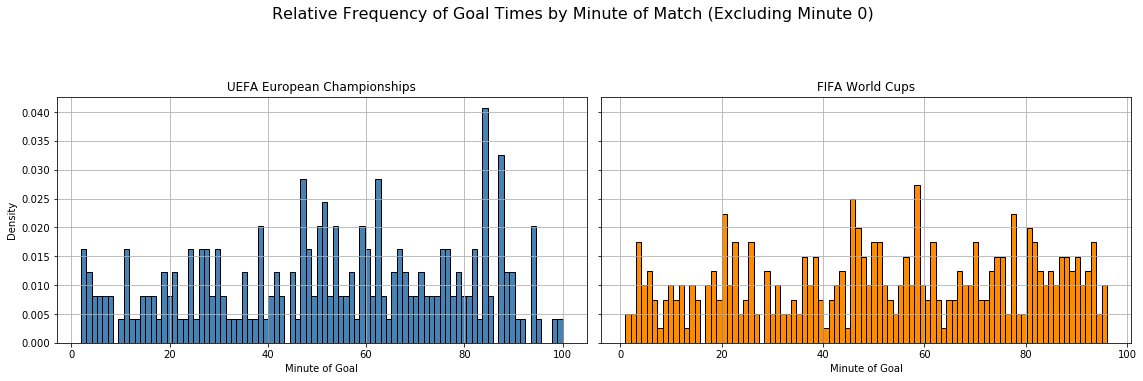

In [106]:
# Filter out zero-minute goals
goals_eu_uefa_filtered = goals_eu_uefa[goals_eu_uefa['goal_minute'] > 0]
goals_wc_fifa_filtered = goals_wc_fifa[goals_wc_fifa['goal_minute'] > 0]

# Plot setup
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# UEFA European Championships
axes[0].hist(goals_eu_uefa_filtered['goal_minute'], bins=90, density=True, color='steelblue', edgecolor='black')
axes[0].set_title('UEFA European Championships')
axes[0].set_xlabel('Minute of Goal')
axes[0].set_ylabel('Density')
axes[0].grid(True)

# FIFA World Cups
axes[1].hist(goals_wc_fifa_filtered['goal_minute'], bins=90, density=True, color='darkorange', edgecolor='black')
axes[1].set_title('FIFA World Cups')
axes[1].set_xlabel('Minute of Goal')
axes[1].grid(True)

# Add suptitle and adjust spacing
fig.suptitle('Relative Frequency of Goal Times by Minute of Match (Excluding Minute 0)', fontsize=16, y=1.05)
plt.tight_layout()
plt.subplots_adjust(top=0.8)  # Add more vertical spacing between suptitle and plots
plt.show()


## Suspense Trajectory Analysis (Stable vs Volatile Groups)

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


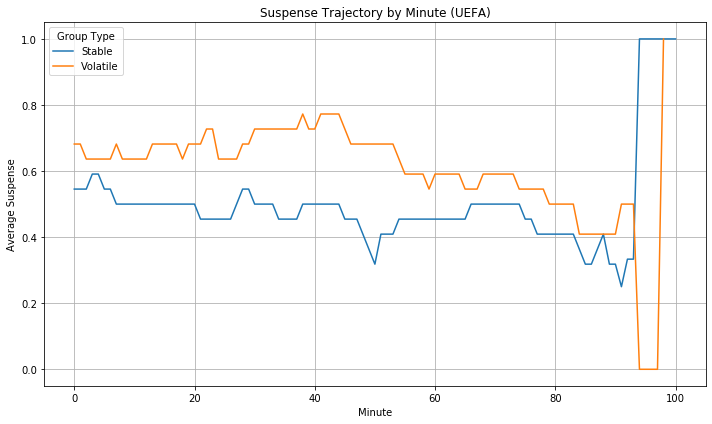

In [ ]:
# Define volatility based on UEFA group qualification count
volatility_threshold = agg_goals_eu_uefa['avg_qual_count'].median()
agg_goals_eu_uefa['volatility'] = agg_goals_eu_uefa['avg_qual_count'].apply(
    lambda x: 'Volatile' if x > volatility_threshold else 'Stable'
)

# Merge volatility labels with minute-by-minute suspense data
mbm_merged = mbm_eu_uefa.merge(
    agg_goals_eu_uefa[['year', 'group', 'volatility']].rename(columns={'group': 'stage'}),
    on=['year', 'stage'],
    how='left'
)

# Aggregate average suspense by minute and volatility type
suspense_trajectory = mbm_merged.groupby(['match_minute', 'volatility'])['suspense'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
for label, df_group in suspense_trajectory.groupby('volatility'):
    plt.plot(df_group['match_minute'], df_group['suspense'], label=label)

plt.title('Suspense Trajectory by Minute (UEFA)')
plt.xlabel('Minute')
plt.ylabel('Average Suspense')
plt.legend(title='Group Type')
plt.grid(True)
plt.tight_layout()
plt.show()


In this analysis, each minute-by-minute observation is labeled as belonging to either a "stable" or "volatile" group based on the average number of qualification changes (`avg_qual_count`) observed in its group (defined by year and stage). Groups with an `avg_qual_count` above the median are classified as volatile, while those below are considered stable. This classification is then merged into the minute-level dataset, allowing us to track how suspense evolves over time for the two types of groups. For each minute of play, we compute the average suspense separately for all observations in stable and volatile groups, creating two suspense trajectories.


## Avg suspense per minute UEFA vs FIFA

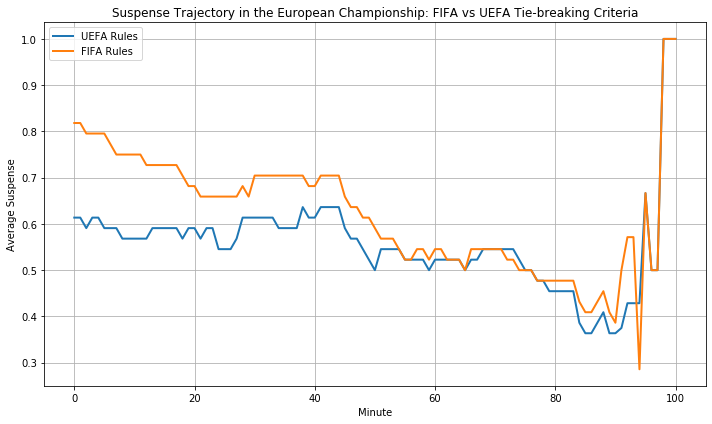

In [ ]:
# Group and compute average suspense per minute
suspense_fifa = mbm_eu_fifa.groupby('match_minute')['suspense'].mean().reset_index(name='suspense_fifa')
suspense_uefa = mbm_eu_uefa.groupby('match_minute')['suspense'].mean().reset_index(name='suspense_uefa')

# Merge on match_minute
suspense_comparison = pd.merge(suspense_uefa, suspense_fifa, on='match_minute')


plt.figure(figsize=(10, 6))
plt.plot(suspense_comparison['match_minute'], suspense_comparison['suspense_uefa'], label='UEFA Rules', linewidth=2)
plt.plot(suspense_comparison['match_minute'], suspense_comparison['suspense_fifa'], label='FIFA Rules', linewidth=2)
plt.xlabel('Minute')
plt.ylabel('Average Suspense')
plt.title('Suspense Trajectory in the European Championship: FIFA vs UEFA Tie-breaking Criteria')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


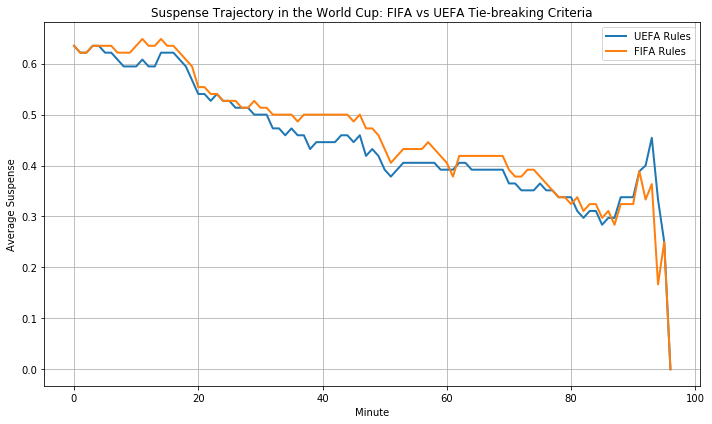

In [ ]:
# Group and compute average suspense per minute
suspense_fifa_wc = mbm_wc_fifa.groupby('match_minute')['suspense'].mean().reset_index(name='suspense_fifa')
suspense_uefa_wc = mbm_wc_uefa.groupby('match_minute')['suspense'].mean().reset_index(name='suspense_uefa')

# Merge on match_minute
suspense_comparison_wc = pd.merge(suspense_uefa_wc, suspense_fifa_wc, on='match_minute')

plt.figure(figsize=(10, 6))
plt.plot(suspense_comparison_wc['match_minute'], suspense_comparison_wc['suspense_uefa'], label='UEFA Rules', linewidth=2)
plt.plot(suspense_comparison_wc['match_minute'], suspense_comparison_wc['suspense_fifa'], label='FIFA Rules', linewidth=2)
plt.xlabel('Minute')
plt.ylabel('Average Suspense')
plt.title('Suspense Trajectory in the World Cup: FIFA vs UEFA Tie-breaking Criteria')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
